# CARMINE — Indicator Plot Routine (Single Maps + Panel Maps)

This notebook consolidates the **single-map** routine (based on `plot-map_2D`) and the **panel-map** routine (based on the indicator panel plotting notebook) into **one** workflow.

**Including**
- User-driven configuration (edit variables in the *User input* cell).
-  path helper: .
- Writes figures only to `outputs/figures/` (ignored by Git).
- Works for *all* indicators by discovering indicator NetCDFs in the CSA `INDICATORS/` folders.

> If you start Jupyter from `notebooks/`, imports work out of the box through the path helper cell (copied from `notebooks/_lib/paths.py`).


In [1]:
# --- Imports ---
from pathlib import Path
import sys
import re
import warnings

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


# Bootstrap: add (one level up) so we can import _lib from repo root
REPO_ROOT_BOOT = Path.cwd().resolve().parent  # assumes we are in .../notebooks
if str(REPO_ROOT_BOOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT_BOOT))

from _lib.paths import (
    REPO_ROOT as REPO_ROOT_HELPER,
    iter_indicators_dirs,
    iter_indicator_files,
)

# Optional: Cartopy (maps)
try:
    import cartopy.crs as ccrs
except Exception:
    ccrs = None

# ✅ From here on: use the helper's repo root (should be CARMINE-T2.4/)
REPO_ROOT = REPO_ROOT_HELPER

WORK      = REPO_ROOT / "notebooks"
OUTPUTS   = REPO_ROOT / "outputs"
FIG_DIR   = OUTPUTS / "figures"
TABLE_DIR = OUTPUTS / "tables"

print("REPO_ROOT:", REPO_ROOT)
print("WORK:", WORK)
print("REPO_ROOT_HELPER:", REPO_ROOT_HELPER)

REPO_ROOT: C:\Users\reinhvlr\OneDrive\Documents\RUB\Projects\CARMINE\Work\carmine-analyses\data\CARMINE-T2.4VR\CARMINE-T2.4
WORK: C:\Users\reinhvlr\OneDrive\Documents\RUB\Projects\CARMINE\Work\carmine-analyses\data\CARMINE-T2.4VR\CARMINE-T2.4\notebooks
REPO_ROOT_HELPER: C:\Users\reinhvlr\OneDrive\Documents\RUB\Projects\CARMINE\Work\carmine-analyses\data\CARMINE-T2.4VR\CARMINE-T2.4


In [2]:
# --- USER INPUT (edit here) ---

# Target selection
CSA_SELECT       = "Funen-Odense"      # e.g., "Barcelona", "Birmingham", "Bologna", "Funen-Odense", "Leipzig"
DATASET_FILTER   = "emo"           # e.g., "eobs", "cerra", "eu-cordex-11" ; "era5" "emo" (Birmingham) not working currently euro cordex nw for Funen-Odense
INDICATOR_SELECT = "ews"           # e.g., "HD", "WSDI", "TXX", "RX5DAY", "CDD", "SU"
PERIOD_SELECT    = "1991-2020"    # e.g., "1981-2010", "1991-2020", "2036-2065"

# Plot styling
CMAP_SINGLE      = "Blues"
CMAP_PANEL       = "Blues"
ROBUST_PCTS      = (2, 98)        # for shared panel color scale (vmin/vmax from percentiles)

# Boundary overlay (optional)
ADD_FUA_BOUNDARY = True
FUA_SHP_REL      = Path("shapefile/UI-boundaries-FUA/FUA_Boundaries.shp")  # relative to repo root
FUA_NAME_FIELD   = "FUA_NAME"     # field name used in the FUA boundary shapefile
FUA_MAPPING = {                  # mapping from CSA folder name -> FUA_NAME (only if needed)
    "Prague": "Praha",
    "Funen-Odense": "Odense",
    "Athens": "Athina",
    "Birmingham": "West Midlands urban area",
}

# Output
SINGLE_OUT_SUBDIR = Path("single_maps")
PANEL_OUT_SUBDIR  = Path("panels")
DPI               = 200
SHOW_PLOTS        = True


In [3]:
# check for existing boundary shapefiles.
import geopandas as gpd

fua_path = REPO_ROOT / FUA_SHP_REL
gdf = gpd.read_file(fua_path)

print("Columns:", list(gdf.columns))
print("CRS:", gdf.crs)
print("Count:", len(gdf))

# show unique names (first 50)
names = sorted(gdf[FUA_NAME_FIELD].dropna().astype(str).unique())
print("Unique FUA names (sample):", names[:50])

Columns: ['OBJECTID', 'FUA_CODE', 'FUA_NAME', 'COUNTRY_CO', 'Shape_Leng', 'Shape_Area', 'geometry']
CRS: EPSG:3035
Count: 672
Unique FUA names (sample): ['Aachen', 'Aalborg', 'Aberdeen', 'Acireale', 'Ajaccio', 'Alba Iulia', 'Albacete', 'Albi', 'Algeciras', 'Alicante/Alacant', 'Alkmaar', 'Almelo', 'Almería', 'Alphen aan den Rijn', 'Alytus', 'Amersfoort', 'Amiens', 'Amsterdam', 'Ancona', 'Angers', 'Angoulème', 'Annecy', 'Annemasse', 'Antwerpen', 'Apeldoorn', 'Arad', 'Arnhem', 'Arras', 'Aschaffenburg', 'Ashford', 'Asti', 'Athina', 'Augsburg', 'Aveiro', 'Avellino', 'Avignon', 'Avilés', 'Bacău', 'Badajoz', 'Baia Mare', 'Bamberg', 'Banská Bystrica', 'Barcelona', 'Bari', 'Barletta', 'Barnsley', 'Basingstoke and Deane', 'Bath and North East Somerset', 'Bayonne', 'Bayreuth']


In [4]:
# --- Helpers (discovery + plotting) ---

def normalize_token(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())

def parse_years_from_string(s: str) -> list[tuple[int,int]]:
    """Return all (YYYY,YYYY) pairs found in a string."""
    s = str(s)
    hits = []
    for m in re.finditer(r"(19\d{2}|20\d{2})\D{0,3}(19\d{2}|20\d{2})", s):
        y1, y2 = int(m.group(1)), int(m.group(2))
        if 1900 <= y1 <= 2100 and 1900 <= y2 <= 2100 and y2 >= y1:
            hits.append((y1, y2))
    return hits

def ensure_lonlat_coords(ds: xr.Dataset, da: xr.DataArray) -> xr.DataArray:
    """
    If ds contains lon/lat (or longitude/latitude) as variables, attach them
    as coords to da (common for CERRA/CORDEX where da dims are y/x).
    """
    # preferred names first
    candidates = [
        ("lon", "lat"),
        ("longitude", "latitude"),
        ("LON", "LAT"),
        ("nav_lon", "nav_lat"),
    ]
    for lon_name, lat_name in candidates:
        if lon_name in ds and lat_name in ds:
            try:
                return da.assign_coords({lon_name: ds[lon_name], lat_name: ds[lat_name]})
            except Exception:
                pass
        if lon_name in ds.coords and lat_name in ds.coords:
            try:
                return da.assign_coords({lon_name: ds.coords[lon_name], lat_name: ds.coords[lat_name]})
            except Exception:
                pass

    return da

def file_matches_filters(fp: Path, indicator_token: str, period_label: str | None, dataset_filter: str | None) -> bool:
    name = fp.name
    if dataset_filter is not None and normalize_token(dataset_filter) not in normalize_token(name):
        return False
    if indicator_token is not None and normalize_token(indicator_token) not in normalize_token(name):
        # still allow if the variable name matches later; but file-level filter helps
        return False
    if period_label:
        yrs = parse_years_from_string(name)
        try:
            y1, y2 = map(int, period_label.split("-"))
        except Exception:
            return True
        if yrs:
            return any((a==y1 and b==y2) for a,b in yrs) or any((a<=y1 and b>=y2) for a,b in yrs)
        # If no years in name, we can't reject it; time axis may cover it
        return True
    return True

def choose_var(ds: xr.Dataset, indicator_token: str):
    """Prefer variable containing token (case-insensitive); else first var."""
    candidates = list(ds.data_vars)
    hits = [v for v in candidates if indicator_token.lower() in v.lower()]
    return hits[0] if hits else candidates[0]

def time_subset_for_period(da: xr.DataArray, period_label: str) -> xr.DataArray:
    """If time axis exists, subset to YYYY-YYYY (inclusive)."""
    if "time" not in getattr(da, "dims", []):
        return da
    try:
        y1, y2 = map(int, period_label.split("-"))
        years = pd.DatetimeIndex(da["time"].values).year
        return da.sel(time=(years >= y1) & (years <= y2))
    except Exception:
        return da

def to_numeric_days_if_timedelta(da: xr.DataArray) -> xr.DataArray:
    """timedelta64 → float days; else force float64 for robust plotting."""
    if np.issubdtype(da.dtype, np.timedelta64):
        out = (da / np.timedelta64(1, "D")).astype("float64")
        units = str(da.attrs.get("units", "")).strip()
        out.attrs["units"] = "days" if units == "" else f"{units} (days)"
        return out
    return da.astype("float64", copy=False)

def reduce_to_map(ds: xr.Dataset, indicator_token: str, period_label: str | None) -> xr.DataArray:
    var = choose_var(ds, indicator_token)
    da = ensure_lonlat_coords(ds, ds[var].squeeze())
    if period_label:
        da = time_subset_for_period(da, period_label)
    if "time" in getattr(da, "dims", []):
        with xr.set_options(keep_attrs=True):
            da = da.mean("time", skipna=True)
    da = to_numeric_days_if_timedelta(da)
    return da

def get_lon_lat_names(obj) -> tuple[str | None, str | None]:
    # Only accept true geographic coordinate names
    for lon, lat in [("lon","lat"), ("longitude","latitude"), ("LON","LAT"), ("nav_lon","nav_lat")]:
        if lon in obj.coords and lat in obj.coords:
            return lon, lat
        if lon in getattr(obj, "dims", []) and lat in getattr(obj, "dims", []):
            return lon, lat

    # If lon/lat exist as *variables* (not coords), allow them too
    for lon, lat in [("lon","lat"), ("longitude","latitude"), ("LON","LAT"), ("nav_lon","nav_lat")]:
        if lon in obj and lat in obj:
            return lon, lat

    # Do NOT fall back to x/y here (those are usually projected)
    return None, None

def load_fua_boundary(csa_name: str):
    if not ADD_FUA_BOUNDARY or gpd is None:
        return None
    shp = (REPO_ROOT / FUA_SHP_REL)
    if not shp.exists():
        warnings.warn(f"FUA shapefile not found at: {shp}")
        return None
    gdf = gpd.read_file(shp)
    fua_name = FUA_MAPPING.get(csa_name, csa_name)
    if FUA_NAME_FIELD in gdf.columns:
        sel = gdf[gdf[FUA_NAME_FIELD].astype(str) == str(fua_name)]
        if sel.empty:
            warnings.warn(f"No FUA boundary found for '{fua_name}' in {shp.name}")
            return None
        return sel
    warnings.warn(f"Field '{FUA_NAME_FIELD}' not in shapefile. Available: {list(gdf.columns)[:10]}...")
    return None

def discover_indicator_files(root: Path | None = None) -> pd.DataFrame:
    """
    Discover NetCDF indicator files under CSA/INDICATORS folders.

    Expected layout:
        REPO_ROOT/
          <CSA_NAME>/
            INDICATORS/
              *.nc

    Returns a DataFrame with columns:
        - csa
        - path
        - name
    """
    root = Path(root) if root is not None else REPO_ROOT

    rows = []

    for csa_dir in root.iterdir():
        if not csa_dir.is_dir():
            continue

        ind_dir = csa_dir / "INDICATORS"
        if not ind_dir.exists():
            continue

        for fp in ind_dir.rglob("*.nc"):
            rows.append({
                "csa": csa_dir.name,
                "path": fp,
                "name": fp.name,
            })

    df = pd.DataFrame(rows)

    if df.empty:
        warnings.warn(
            f"No indicator NetCDF files found under {root}. "
            "Check repo layout and INDICATORS folder names."
        )

    return df

def plot_map_2d(
    da: xr.DataArray,
    title: str,
    out_png: Path,
    cmap: str = "Blues",
    vmin=None,
    vmax=None,
    boundary_gdf=None,
    dpi: int = 200,
    show: bool = True,
):
    """Plot a single 2D DataArray map.
    Uses Cartopy if available; otherwise falls back to imshow.
    """
    da = da.squeeze()

    # Always define these so we never get NameError
    fig = plt.figure(figsize=(7, 6))
    ax = None
    cbar = None

    lon_name, lat_name = get_lon_lat_names(da)
    lon = da[lon_name].values if lon_name and lon_name in da.coords else None
    lat = da[lat_name].values if lat_name and lat_name in da.coords else None
    arr = np.asarray(da.values, dtype="float64")

    use_cartopy = (ccrs is not None) and (lon is not None) and (lat is not None)

    if use_cartopy:
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines(resolution="10m", linewidth=0.6)

        if getattr(lon, "ndim", 0) == 1 and getattr(lat, "ndim", 0) == 1:
            extent = [
                float(np.nanmin(lon)), float(np.nanmax(lon)),
                float(np.nanmin(lat)), float(np.nanmax(lat)),
            ]
            im = ax.imshow(arr, origin="lower", extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = ax.pcolormesh(lon, lat, arr, cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")

        # Boundary overlay + zoom ONLY possible with cartopy axis
        if boundary_gdf is not None:
            try:
                bg = boundary_gdf
                if getattr(bg, "crs", None) is not None:
                    bg = bg.to_crs("EPSG:4326")

                bg.boundary.plot(ax=ax, linewidth=1.2, color="black")

                minx, miny, maxx, maxy = bg.total_bounds
                pad_x = (maxx - minx) * 0.15
                pad_y = (maxy - miny) * 0.15
                ax.set_extent(
                    [minx - pad_x, maxx + pad_x, miny - pad_y, maxy + pad_y],
                    crs=ccrs.PlateCarree(),
                )
            except Exception as e:
                warnings.warn(f"Failed to plot or zoom boundary: {e}")

        ax.set_title(title)
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.05)

    else:
        ax = plt.gca()
        im = ax.imshow(arr, origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title + " (no cartopy)")
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.05)

    # Safe colorbar label
    units = str(da.attrs.get("units", "")).strip()
    if units and cbar is not None:
        cbar.set_label(units)

    out_png = Path(out_png)
    out_png.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_png, dpi=dpi, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    print("Saved:", out_png)

(info) Building files_df via discover_indicator_files() ...
(info) Discovered: 466 files
CSA_SELECT: Funen-Odense
INDICATOR_SELECT: ews | PERIOD_SELECT: 1991-2020 | DATASET_FILTER: emo
Candidates: 1


,csa,path,name,period_pref
0,Funen-Odense,C:\Users\reinhvlr\OneDrive\Documents\RUB\Proje...,funen_emo_ews_1991-2020.nc,0


Using: C:\Users\reinhvlr\OneDrive\Documents\RUB\Projects\CARMINE\Work\carmine-analyses\data\CARMINE-T2.4VR\CARMINE-T2.4\Funen-Odense\INDICATORS\funen_emo_ews_1991-2020.nc
da_map dims: ('lat', 'lon') | shape: (14, 25)
da_map min/max: 10.600000000000001 12.700000000000001


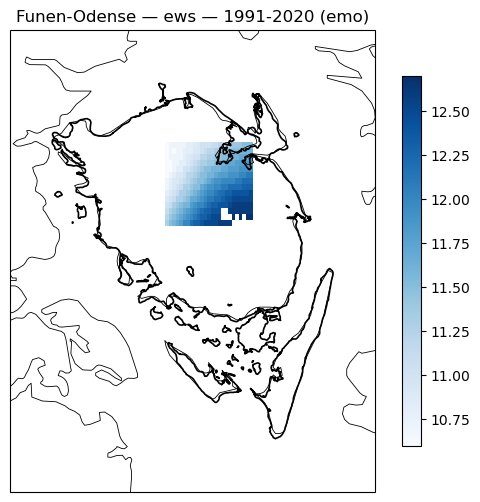

Saved: C:\Users\reinhvlr\OneDrive\Documents\RUB\Projects\CARMINE\Work\carmine-analyses\data\CARMINE-T2.4VR\CARMINE-T2.4\outputs\figures\single_maps\Funen-Odense_emo_ews_1991-2020.png
Done. Saved to: C:\Users\reinhvlr\OneDrive\Documents\RUB\Projects\CARMINE\Work\carmine-analyses\data\CARMINE-T2.4VR\CARMINE-T2.4\outputs\figures\single_maps\Funen-Odense_emo_ews_1991-2020.png | exists: True


In [5]:
# ============================================================
# PART 1 — SINGLE MAPS (one CSA, one indicator, one period)
# ============================================================

# --- Ensure file inventory exists ---
if "files_df" not in globals() or files_df is None or len(files_df) == 0:
    print("(info) Building files_df via discover_indicator_files() ...")
    files_df = discover_indicator_files()
    print("(info) Discovered:", len(files_df), "files")
else:
    print("(info) Using existing files_df with", len(files_df), "files")

# --- Select candidate files (ROBUST matching like yesterday) ---
cand = files_df.copy()

# CSA match (case-insensitive)
cand = cand[cand["csa"].astype(str).str.strip().str.lower() == str(CSA_SELECT).strip().lower()].copy()

# normalize names once to avoid hyphen/underscore issues (eu-cordex-11 vs eu_cordex_11 etc.)
cand["name_norm"] = cand["name"].astype(str).apply(normalize_token)

# Dataset filter (robust)
if DATASET_FILTER:
    cand = cand[cand["name_norm"].str.contains(normalize_token(DATASET_FILTER), na=False)]

# Indicator filter (robust)
cand = cand[cand["name_norm"].str.contains(normalize_token(INDICATOR_SELECT), na=False)]

# Prefer period matches (based on years parsed from filename, but tolerant)
y1, y2 = map(int, PERIOD_SELECT.split("-"))

def _pref_period(name: str) -> int:
    yrs = parse_years_from_string(name)
    if not yrs:
        return 1  # unknown -> keep but lower preference
    return 0 if any((a == y1 and b == y2) or (a <= y1 and b >= y2) for a, b in yrs) else 2

cand["period_pref"] = cand["name"].apply(_pref_period)
cand = cand.sort_values(["period_pref", "name"]).reset_index(drop=True)

print("CSA_SELECT:", CSA_SELECT)
print("INDICATOR_SELECT:", INDICATOR_SELECT, "| PERIOD_SELECT:", PERIOD_SELECT, "| DATASET_FILTER:", DATASET_FILTER)
print("Candidates:", len(cand))
display(cand[["csa", "path", "name", "period_pref"]].head(20))

if cand.empty:
    raise FileNotFoundError(
        "No indicator file found for the given selection. "
        "Adjust CSA/indicator/dataset/period filters."
    )

# --- Pick best candidate ---
fp = Path(cand.iloc[0]["path"])
print("Using:", fp)

# Dataset tag for output filename
dataset_tag = DATASET_FILTER if DATASET_FILTER else "mixed"

# --- Load -> reduce to 2D map ---
ds = xr.open_dataset(fp, decode_timedelta=True)
try:
    da_map = reduce_to_map(ds, INDICATOR_SELECT, PERIOD_SELECT)
finally:
    try:
        ds.close()
    except Exception:
        pass

arr = np.asarray(da_map.values)
print("da_map dims:", da_map.dims, "| shape:", da_map.shape)
with np.errstate(all="ignore"):
    print("da_map min/max:", float(np.nanmin(arr)), float(np.nanmax(arr)))

# --- Boundary + output path ---
boundary = load_fua_boundary(CSA_SELECT)  # may be None (that's fine)
out_png = FIG_DIR / SINGLE_OUT_SUBDIR / f"{CSA_SELECT}_{dataset_tag}_{INDICATOR_SELECT}_{PERIOD_SELECT}.png"

# --- Plot + save ---
plot_map_2d(
    da_map,
    title=f"{CSA_SELECT} — {INDICATOR_SELECT} — {PERIOD_SELECT} ({dataset_tag})",
    out_png=out_png,
    cmap=CMAP_SINGLE,
    boundary_gdf=boundary,
    dpi=DPI,
    show=SHOW_PLOTS,
)

print("Done. Saved to:", out_png, "| exists:", out_png.exists())

(info) Using existing files_df with 466 files
Panel selection: dataset= emo | indicator= ews | period= 1991-2020
CSAs with candidate file: 1


,csa,path,name
0,Funen-Odense,C:\Users\reinhvlr\OneDrive\Documents\RUB\Proje...,funen_emo_ews_1991-2020.nc


Loaded snapshots: 1
Common scale: 10.600000000000001 → 12.600000000000001


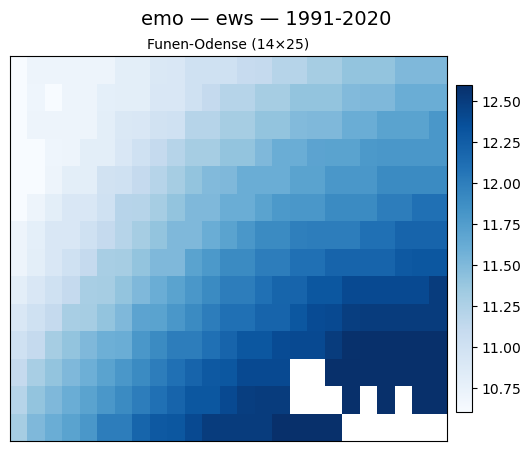

Saved panel to: C:\Users\reinhvlr\OneDrive\Documents\RUB\Projects\CARMINE\Work\carmine-analyses\data\CARMINE-T2.4VR\CARMINE-T2.4\outputs\figures\panels\panel_emo_ews_1991-2020.png | exists: True


In [6]:
# ============================================================
# PART 2 — PANEL MAPS (all CSAs for one indicator + period)
# ============================================================
#
# Goal: produce a quick, comparable overview across CSAs for the *selected*
# dataset + indicator + period, using the same helper functions as Part 1.
#
# Notes:
# - Panel plots use plain imshow (no cartopy), because CSAs may have different
#   spatial extents / grids (especially if indicator NetCDFs are pre-cropped).
# - A shared color scale is computed across all included CSAs using robust
#   percentiles (ROBUST_PCTS).

# --- Ensure file inventory exists (after kernel restart) ---
if "files_df" not in globals() or files_df is None or len(files_df) == 0:
    print("(info) Building files_df via discover_indicator_files() ...")
    files_df = discover_indicator_files()
    print("(info) Discovered:", len(files_df), "files")
else:
    print("(info) Using existing files_df with", len(files_df), "files")

if len(files_df) == 0:
    raise RuntimeError("files_df is empty. Fix discover_indicator_files() root=... first.")

# --- Local helpers used by Part 2 (self-contained) ---
def _pref_period_for_name(name: str, period_label: str) -> int:
    """Lower is better. Prefers files that match/cover the requested period in filename."""
    yrs = parse_years_from_string(name)
    if not yrs:
        return 1  # unknown -> keep but lower preference
    y1, y2 = map(int, period_label.split("-"))
    return 0 if any((a == y1 and b == y2) or (a <= y1 and b >= y2) for a, b in yrs) else 2

dataset_tag = DATASET_FILTER if DATASET_FILTER else "mixed"

print("Panel selection:",
      "dataset=", dataset_tag,
      "| indicator=", INDICATOR_SELECT,
      "| period=", PERIOD_SELECT)

# --- Build one file per CSA (best matching file) ---
panel_rows = []
for csa in sorted(files_df["csa"].dropna().unique()):
    sub = files_df[files_df["csa"].astype(str) == str(csa)].copy()

    if DATASET_FILTER:
        sub = sub[sub["name"].str.lower().str.contains(str(DATASET_FILTER).lower(), na=False)]

    # coarse file-level indicator filter (variable selection happens in reduce_to_map too)
    sub = sub[sub["name"].str.lower().str.contains(str(INDICATOR_SELECT).lower(), na=False)]

    if sub.empty:
        continue

    sub["period_pref"] = sub["name"].apply(lambda n: _pref_period_for_name(n, PERIOD_SELECT))
    sub = sub.sort_values(["period_pref", "name"]).reset_index(drop=True)

    panel_rows.append({"csa": csa, "path": Path(sub.iloc[0]["path"]), "name": sub.iloc[0]["name"]})

panel_df = pd.DataFrame(panel_rows)
print("CSAs with candidate file:", len(panel_df))
display(panel_df.head(20))

if panel_df.empty:
    print("No CSA snapshots available to plot (after filters).")
else:
    # --- Load + reduce each CSA to a 2D map ---
    snapshots: dict[str, xr.DataArray] = {}
    skipped: list[tuple[str, str]] = []

    for _, row in panel_df.iterrows():
        csa = row["csa"]
        fp = Path(row["path"])
        try:
            ds = xr.open_dataset(fp, decode_timedelta=True)
            da_map = reduce_to_map(ds, INDICATOR_SELECT, PERIOD_SELECT)
            # Ensure it's 2D-ish for plotting (we use imshow)
            da_map = da_map.squeeze()
            if len(getattr(da_map, "shape", ())) < 2:
                skipped.append((csa, f"not 2D after reduce ({da_map.dims})"))
            else:
                snapshots[csa] = da_map
        except Exception as e:
            skipped.append((csa, f"{type(e).__name__}: {e}"))
        finally:
            try:
                ds.close()
            except Exception:
                pass

    print("Loaded snapshots:", len(snapshots))
    if skipped:
        print("Skipped (first 15):", skipped[:15], f"… total {len(skipped)}")

    # --- Shared color scale (robust percentiles across all CSAs) ---
    if snapshots:
        all_vals = []
        for da_map in snapshots.values():
            v = np.asarray(da_map.values, dtype="float64").ravel()
            v = v[np.isfinite(v)]
            if v.size:
                all_vals.append(v)
        if all_vals:
            vcat = np.concatenate(all_vals)
            p_lo, p_hi = ROBUST_PCTS
            vmin = float(np.nanpercentile(vcat, p_lo))
            vmax = float(np.nanpercentile(vcat, p_hi))
            if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
                vmin, vmax = None, None
        else:
            vmin, vmax = None, None

        print("Common scale:", vmin, "→", vmax)

        # --- Render panel ---
        items = list(snapshots.items())
        N = len(items)

        ncols = 3 if N >= 9 else 2 if N >= 4 else 1
        nrows = int(np.ceil(N / ncols))

        fig, axes = plt.subplots(
            nrows, ncols,
            figsize=(5.2 * ncols, 4.4 * nrows),
            constrained_layout=True
        )
        axes = np.atleast_1d(axes).reshape(nrows, ncols)

        mappable = None
        for i, (csa, da_map) in enumerate(items):
            r, c = divmod(i, ncols)
            ax = axes[r, c]

            arr = np.asarray(da_map.values, dtype="float64")
            im = ax.imshow(arr, origin="lower", cmap=CMAP_PANEL, vmin=vmin, vmax=vmax, aspect="auto")
            mappable = im

            # Small title with CSA + grid size
            ax.set_title(f"{csa} ({arr.shape[0]}×{arr.shape[1]})", fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])

        # Hide unused axes
        for j in range(N, nrows * ncols):
            r, c = divmod(j, ncols)
            axes[r, c].axis("off")

        # Colorbar + title + save
        if mappable is not None:
            cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.85, pad=0.02)
            # Try to label units (first snapshot)
            first_units = str(next(iter(snapshots.values())).attrs.get("units", "")).strip()
            if first_units:
                cbar.set_label(first_units)

        fig.suptitle(f"{dataset_tag} — {INDICATOR_SELECT} — {PERIOD_SELECT}", fontsize=14)

        out_png = FIG_DIR / PANEL_OUT_SUBDIR / f"panel_{dataset_tag}_{INDICATOR_SELECT}_{PERIOD_SELECT}.png"
        out_png.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_png, dpi=DPI, bbox_inches="tight")

        if SHOW_PLOTS:
            plt.show()
        else:
            plt.close(fig)

        print("Saved panel to:", out_png, "| exists:", out_png.exists())
